This will be our project proposal

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [2]:
tennis <- read_csv("Tennis_Stats_Data.csv")
#tennis 

New names:
• `` -> `...1`
Rows: 6866 Columns: 50
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (16): tourney_id, tourney_name, surface, tourney_level, winner_seed, win...
dbl (34): ...1, draw_size, tourney_date, match_num, winner_id, winner_ht, wi...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Used Variables:

First Column (which we will rename ID_Num),
Height,
Age,
Hand,
Rank,
Ace,
Double Faults (df),
Surface

75% Training 25% Testing

In [23]:
tennis_named <- tennis|>
    rename("ID_num" = 1 )
tennis_smaller <- tennis_named|>
    select(ID_num,winner_hand,winner_ht,winner_age,w_ace, w_df,
                         winner_rank,surface)|>
    mutate(ID_num = as_factor(ID_num), winner_hand = as_factor(winner_hand))
tennis_smaller|>
    slice(1:10)

ID_num,winner_hand,winner_ht,winner_age,w_ace,w_df,winner_rank,surface
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0,R,178,29.00479,3,3,9,Hard
1,R,NA,22.88569,10,1,16,Hard
2,R,178,29.00479,2,2,9,Hard
3,R,188,33.70568,12,2,239,Hard
4,R,NA,22.88569,12,3,16,Hard
5,R,188,31.88227,10,8,40,Hard
6,R,178,29.00479,5,2,9,Hard
7,R,188,33.70568,11,3,239,Hard
8,R,NA,19.86858,1,1,31,Hard


In [24]:
tennis_mean <- tennis_smaller|>
    group_by(winner_rank, surface)|>
    summarize(mean_ht = mean(winner_ht, na.rm = TRUE), mean_age = mean(winner_age), 
              mean_ace = mean(w_ace, na.rm = TRUE), mean_df = mean(w_df, na.rm = TRUE))
tennis_mean|>
    slice(1:10)

`summarise()` has grouped output by 'winner_rank'. You can override using the
`.groups` argument.


winner_rank,surface,mean_ht,mean_age,mean_ace,mean_df
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,Clay,186.9556,31.59334,2.720930,2.302326
1,Grass,187.0500,32.65722,7.350000,2.850000
1,Hard,186.8072,32.02405,5.481928,2.048193
2,Clay,186.0286,31.78089,2.735294,1.500000
2,Grass,185.0000,34.59890,8.437500,1.187500
2,Hard,185.7397,33.83736,7.154930,1.873239
3,Clay,194.7500,26.38415,6.741935,1.806452
3,Grass,187.0000,35.31133,8.384615,1.538462
3,Hard,190.5286,31.31679,9.565217,2.753623


In [25]:
tennis_split <- initial_split(tennis_mean, prop = 0.75, strata = winner_rank )
tennis_training <- training(tennis_split)
tennis_testing <- testing(tennis_split)

In [26]:
tennis_training

winner_rank,surface,mean_ht,mean_age,mean_ace,mean_df
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,Clay,186.9556,31.59334,2.720930,2.3023256
1,Grass,187.0500,32.65722,7.350000,2.8500000
1,Hard,186.8072,32.02405,5.481928,2.0481928
2,Clay,186.0286,31.78089,2.735294,1.5000000
2,Grass,185.0000,34.59890,8.437500,1.1875000
2,Hard,185.7397,33.83736,7.154930,1.8732394
3,Hard,190.5286,31.31679,9.565217,2.7536232
5,Grass,188.2308,32.62486,9.384615,2.1538462
5,Hard,191.0133,25.90691,8.822785,2.8354430


Warning message:
“Removed 1 rows containing missing values (geom_point).”


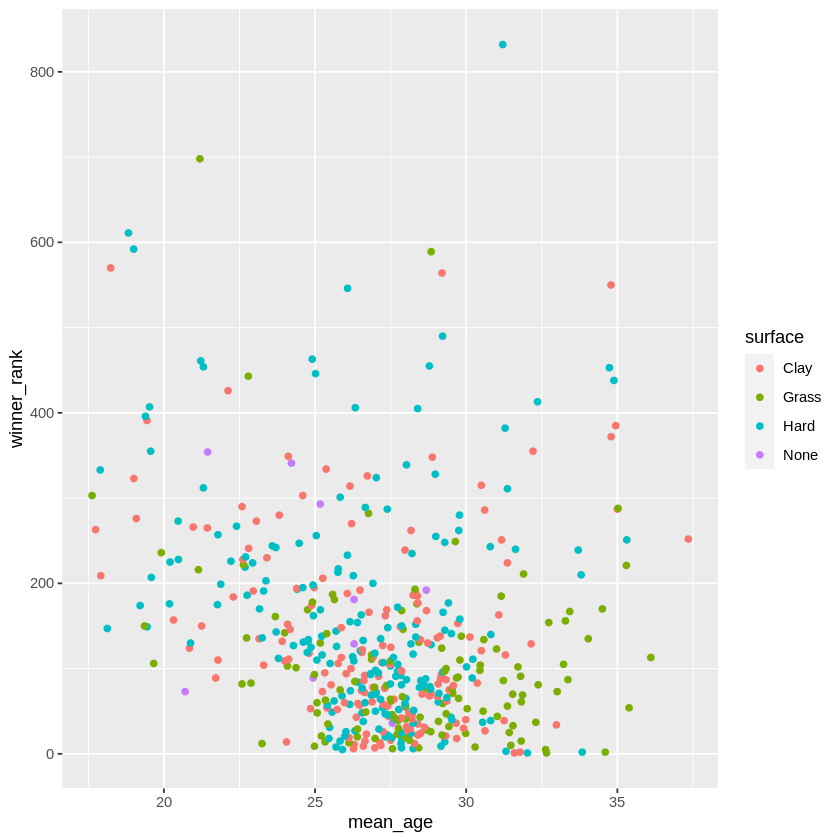

In [28]:
tennis_training_plot<- tennis_training|>
    ggplot(aes(x=mean_age, y=winner_rank, colour = surface))+
    geom_point()
tennis_training_plot